### Application of the LBM and LRR algorithms on and image sequence
In this notebook, we will apply the Latice Boltzman Method (LBM) coupled with the Low Rank Representation : GoDec (LRR) on an image sequence to get the velocity field of the sequence

In [3]:
# Import the functiond from the .py files
from flowAlgorithm import flow_algorithm
from flowAlgorithm2 import flow_algorithm2
from goDec import godec

# Import the libraries
import skimage.io as io
import numpy as np
import os
import cv2
import time
from matplotlib import pyplot as plt

In [4]:
# Define the path to the images or the video

video_file_path = "./Resources/demo.mp4"
frames_save_path = "./Resources/frames"
frame_name_prefix = "frame_"

In [5]:
# Get the image sequence
if not os.path.exists(frames_save_path):
    os.makedirs(frames_save_path)
    # Start capturing the video
    video = cv2.VideoCapture(video_file_path)

    if not video.isOpened():
        print("Error: Could not open video.")
    else:
        frame_index = 0
        while True:
            ret, frame = video.read()
            # If the frame was not retrieved, we've reached the end of the video (or there's an error)
            if not ret:
                break

            # Construct the frame save path
            frame_save_path = os.path.join(frames_save_path, f"{frame_name_prefix}{frame_index}.jpg")
            
            # Save the frame
            cv2.imwrite(frame_save_path, frame)
            print(f"Saved {frame_save_path}")
            
            frame_index += 1

        # Release the video capture object
        video.release()
        print("Video processing complete.")

print("Importing the frames.")
# Extract the frames
nb_frames = len([name for name in os.listdir(frames_save_path) if os.path.isfile(os.path.join(frames_save_path, name))])
shape = io.imread(os.path.join(frames_save_path, f"{frame_name_prefix}0.jpg")).shape
video = np.zeros((nb_frames,shape[0],shape[1]))
for i in range(51):
    frame_save_path = os.path.join(frames_save_path, f"{frame_name_prefix}{i}.jpg")
    video[i,:,:] = io.imread(frame_save_path, as_gray=True)
print("Imported all the frames.")

Importing the frames.
Imported all the frames.


Now that we have all the frames, we can use the GoDec Algorithm. Given matrix X, the algorithm splits it in three matrices:
- L : matrix with rank r
- S : sparce matrix with exactly k elements
- W : the error matrix

In [6]:
# Chosing the parameters for GoDec
r = 2
k = 80*len(video) # Equivalent to 20 active pixels per frame
print("k",k)
epsilon = 0.01
q = 3
print(video.shape)
L, S, W, error_history = godec(video,r,k,q,10,0.01)


k 4080
(51, 48, 48)
S.shape (2304, 51)
iter:  1 error:  0.02961464308009213
iter:  2 error:  0.029614643045789295
iter:  3 error:  0.029614642990886675
iter:  4 error:  0.029614642986953092
iter:  5 error:  0.029614642981476102
iter:  6 error:  0.029614642983815585
iter:  7 error:  0.029614642987973325
iter:  8 error:  0.02961464298947634
iter:  9 error:  0.02961464309571057
iter:  10 error:  0.02961464312816054
S.shape (51, 48, 48)


Text(0.5, 1.0, 'Sparse component')

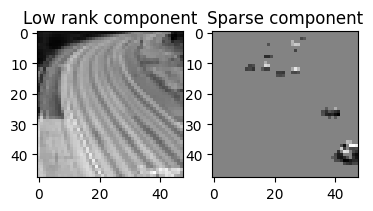

In [7]:
# chose which frame to display
frame = 35

plt.figure()
plt.subplot(1,3,1)
plt.imshow(L[frame, :,: ],cmap='gray')
plt.title('Low rank component')
plt.subplot(1,3,2)
plt.imshow(S[frame, :,:],cmap='gray')
plt.title('Sparse component')

In [8]:
# Define the parameters for the flow algorithm
rho = S  # Sparse component
N = 5  # Number of correction cycles
omega_fr = 0.1  # Relaxation frequency
omega_tilde = 0.1  # Correction rate
nbFrames = rho.shape[0]  # Number of frames in the video (put 1 if you have 2 frames)

# Apply the flow algorithm
start = time.time()
velocity_field = flow_algorithm(rho, N, omega_fr, omega_tilde, nbFrames)
end = time.time()
print('Time: ', end-start)

Time:  111.1104199886322


We can now visualize the result by ploting the magnitude of the output velocity field

In [9]:
# Frame to display
frame = 35

In [10]:
# Compute the speed magnitude of the velocity field at each pixel on each frame
speed_magnitude = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(rho.shape[1]):
        for y in range(rho.shape[2]):
            speed_magnitude[t, x, y] = np.linalg.norm(velocity_field[t, x, y, :])

In [11]:
# Images are upside down, so we need to flip them
speed_magnitude_frame = speed_magnitude[frame, :, :]
speed_magnitude_frame = np.flipud(speed_magnitude_frame)
original_frame = np.flipud(video[frame, :, :])

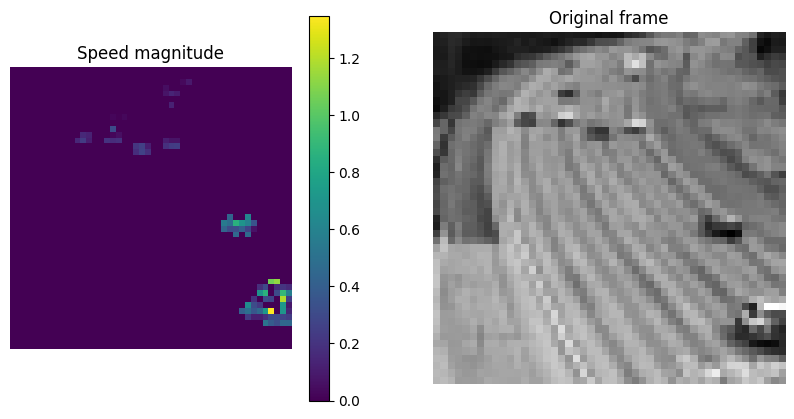

In [12]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()
#plt.quiver(velocity_field[frame, :, :, 0], velocity_field[frame, :, :, 1], color='r')
# sorties en video

In [13]:
start = time.time()
velocity_field_1 = flow_algorithm(video, N, omega_fr, omega_tilde, nbFrames)
end = time.time()
print('Time: ', end-start)

Time:  179.70967364311218


In [14]:
speed_magnitude_1 = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(video.shape[1]):
        for y in range(video.shape[2]):
            speed_magnitude_1[t, x, y] = np.linalg.norm(velocity_field_1[t, x, y, :])

In [15]:
# Images are upside down, so we need to flip them
speed_magnitude_frame_1 = speed_magnitude_1[frame, :, :]
speed_magnitude_frame_1 = np.flipud(speed_magnitude_frame_1)
original_frame = np.flipud(video[frame, :, :])

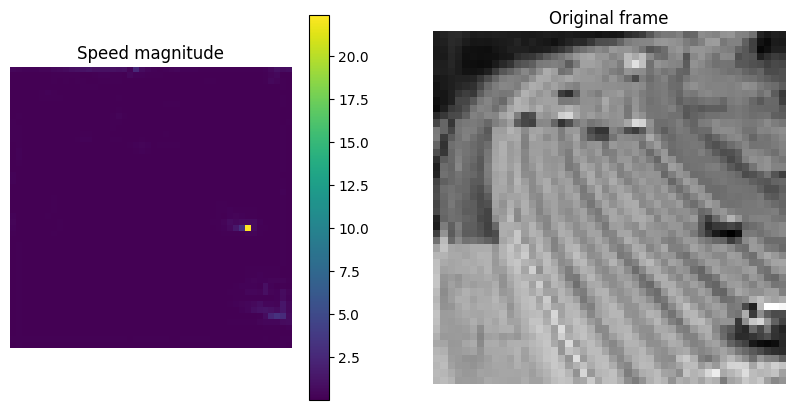

In [16]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame_1, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude_1[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()
#plt.quiver(velocity_field[frame, :, :, 0], velocity_field[frame, :, :, 1], color='r')
# sorties en video

## Application de flowAlgorithm2 sur la vidéo

In [18]:
start = time.time()
velocity_field_2 = flow_algorithm2(video, N, omega_fr, omega_tilde, nbFrames)
end = time.time()
print('Time: ', end-start)

C:\Users\dell\Documents\GitHub\LLBMOF-project\flowAlgorithm2.py:27: RuntimeWarning: overflow encountered in double_scalars
  sum_v_1 = a**2
C:\Users\dell\Documents\GitHub\LLBMOF-project\flowAlgorithm2.py:35: RuntimeWarning: invalid value encountered in double_scalars
  sum_v = 1+3*a + (9/2.0)*sum_v_1-sum_v_2
C:\Users\dell\Documents\GitHub\LLBMOF-project\flowAlgorithm2.py:35: RuntimeWarning: overflow encountered in double_scalars
  sum_v = 1+3*a + (9/2.0)*sum_v_1-sum_v_2
C:\Users\dell\Documents\GitHub\LLBMOF-project\flowAlgorithm2.py:69: RuntimeWarning: invalid value encountered in multiply
  velocity += epsilon[i] * f_s_xyt[i]
C:\Users\dell\Documents\GitHub\LLBMOF-project\flowAlgorithm2.py:38: RuntimeWarning: invalid value encountered in double_scalars
  f_c = f_s[i,x,y,t] - omega_fr*(f_s[i,x,y,t]-f_eq) # Collision


Time:  142.1744577884674


In [19]:
speed_magnitude_2 = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(video.shape[1]):
        for y in range(video.shape[2]):
            speed_magnitude_2[t, x, y] = np.linalg.norm(velocity_field_2[t, x, y, :])

In [21]:
# Images are upside down, so we need to flip them
speed_magnitude_frame_2 = speed_magnitude_2[frame, :, :]
speed_magnitude_frame_2 = np.flipud(speed_magnitude_frame_2)
original_frame = np.flipud(video[frame, :, :])

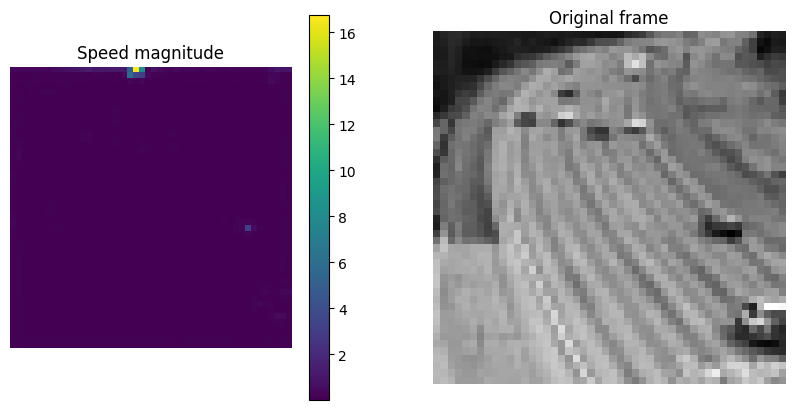

In [23]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame_2, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude_2[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()
#plt.quiver(velocity_field[frame, :, :, 0], velocity_field[frame, :, :, 1], color='r')
# sorties en video

In [24]:
velocity_field_3 = np.abs(velocity_field_1 - velocity_field_2)

In [25]:
speed_magnitude_3 = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(video.shape[1]):
        for y in range(video.shape[2]):
            speed_magnitude_3[t, x, y] = np.linalg.norm(velocity_field_3[t, x, y, :])

In [26]:
# Images are upside down, so we need to flip them
speed_magnitude_frame_3 = speed_magnitude_3[frame, :, :]
speed_magnitude_frame_3 = np.flipud(speed_magnitude_frame_3)
original_frame = np.flipud(video[frame, :, :])

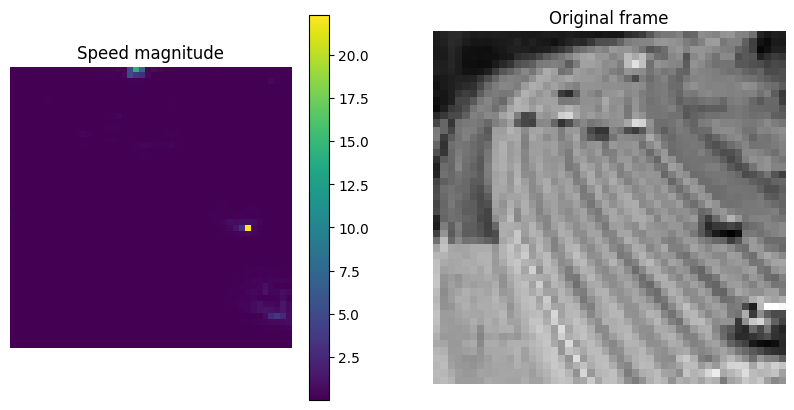

In [27]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame_3, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude_3[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()
#plt.quiver(velocity_field[frame, :, :, 0], velocity_field[frame, :, :, 1], color='r')
# sorties en video

## Application de flowAlgorithm2 sur S

In [37]:
start = time.time()
velocity_field_4 = flow_algorithm2(S, N, omega_fr, omega_tilde, nbFrames)
end = time.time()
print('Time: ', end-start)

Time:  149.85460257530212


In [38]:
speed_magnitude_4 = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(video.shape[1]):
        for y in range(video.shape[2]):
            speed_magnitude_4[t, x, y] = np.linalg.norm(velocity_field_4[t, x, y, :])

In [39]:
# Images are upside down, so we need to flip them
speed_magnitude_frame_4 = speed_magnitude_4[frame, :, :]
speed_magnitude_frame_4 = np.flipud(speed_magnitude_frame_4)
original_frame = np.flipud(video[frame, :, :])

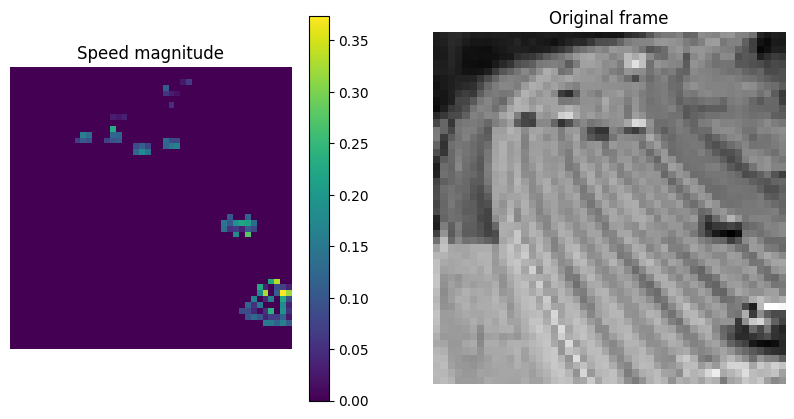

In [40]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame_4, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude_4[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()
#plt.quiver(velocity_field[frame, :, :, 0], velocity_field[frame, :, :, 1], color='r')
# sorties en video

In [41]:
velocity_field_5 = np.abs(velocity_field - velocity_field_4)

In [42]:
speed_magnitude_5 = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(video.shape[1]):
        for y in range(video.shape[2]):
            speed_magnitude_5[t, x, y] = np.linalg.norm(velocity_field_5[t, x, y, :])

In [43]:
# Images are upside down, so we need to flip them
speed_magnitude_frame_5 = speed_magnitude_5[frame, :, :]
speed_magnitude_frame_5 = np.flipud(speed_magnitude_frame_5)
original_frame = np.flipud(video[frame, :, :])

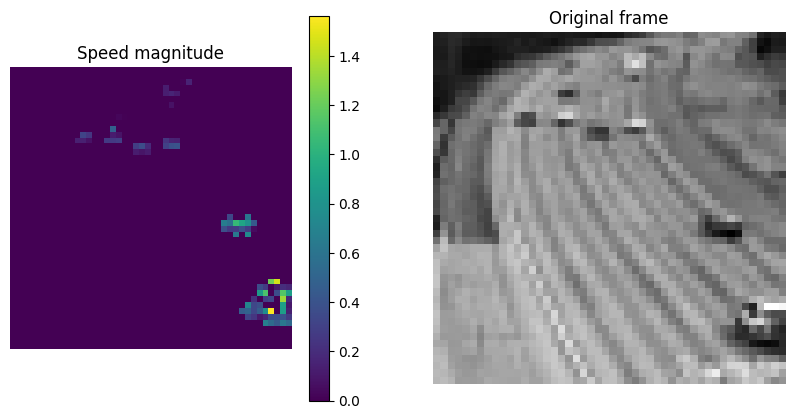

In [44]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame_5, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude_5[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()
#plt.quiver(velocity_field[frame, :, :, 0], velocity_field[frame, :, :, 1], color='r')
# sorties en video